In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

Matplotlib is building the font cache; this may take a moment.


## 3 Visualize Regularization Contours

x.shape: (2, 100), "y.shape:" (1, 100)


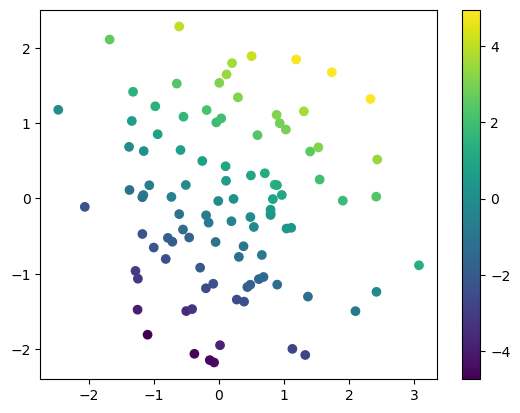

In [2]:
# load the data
data = np.load("data/linreg.npz")
x = data["X"]
y = data["Y"]
print(f'x.shape: {x.shape}, "y.shape:" {y.shape}')
plt.scatter(*x, c=y)
plt.colorbar()
plt.show()

In [3]:
# create a grid of points in the parameter space
b1, b2 = np.linspace(-1, 3, 101), np.linspace(-1, 3, 101)
bs = np.stack(np.meshgrid(b1, b2, indexing="ij"), axis=-1)
bs.shape

(101, 101, 2)

### (a)

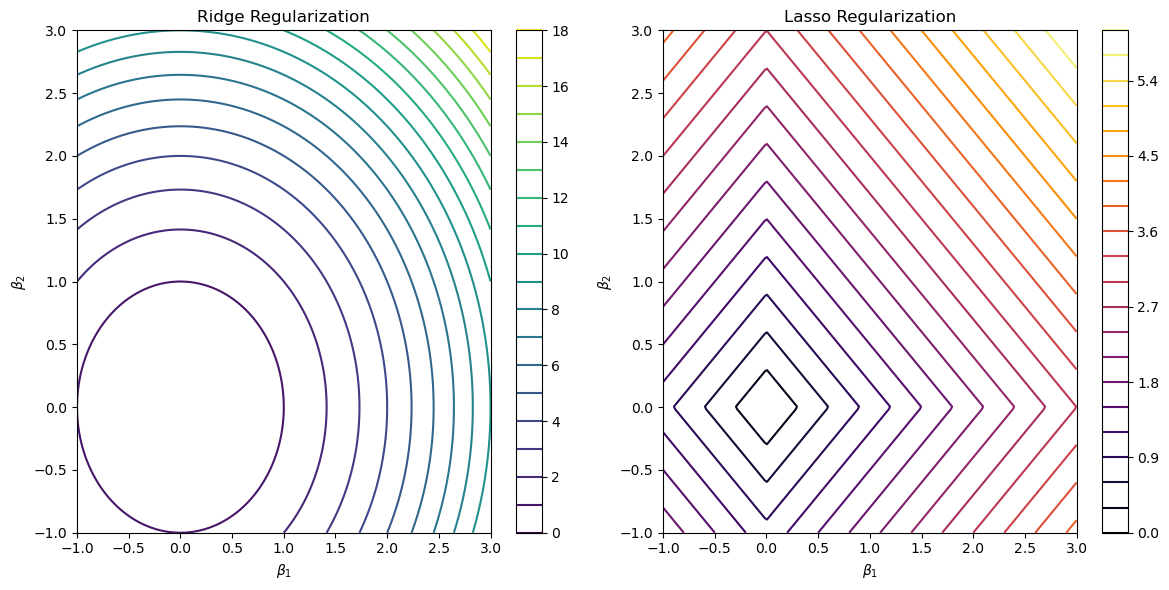

In [4]:

# Ridge regularization term: lambda * (beta1^2 + beta2^2)
lambda_ridge = 1
ridge = lambda_ridge * (bs**2).sum(axis=-1)

# Lasso regularization term: lambda * (|beta1| + |beta2|)
lambda_lasso = 1
lasso = lambda_lasso * np.abs(bs).sum(axis=-1)

# Create the contour plots for Ridge and Lasso
plt.figure(figsize=(12, 6))

# Plot Ridge regularization term
plt.subplot(1, 2, 1)
cp_ridge = plt.contour(bs[..., 0], bs[..., 1], ridge, levels=50, cmap="viridis")
plt.title("Ridge Regularization")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.colorbar(cp_ridge)

# Plot Lasso regularization term
plt.subplot(1, 2, 2)
cp_lasso = plt.contour(bs[..., 0], bs[..., 1], lasso, levels=50, cmap="inferno")
plt.title("Lasso Regularization")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.colorbar(cp_lasso)

# Show the plots
plt.tight_layout()
plt.show()

### (b)

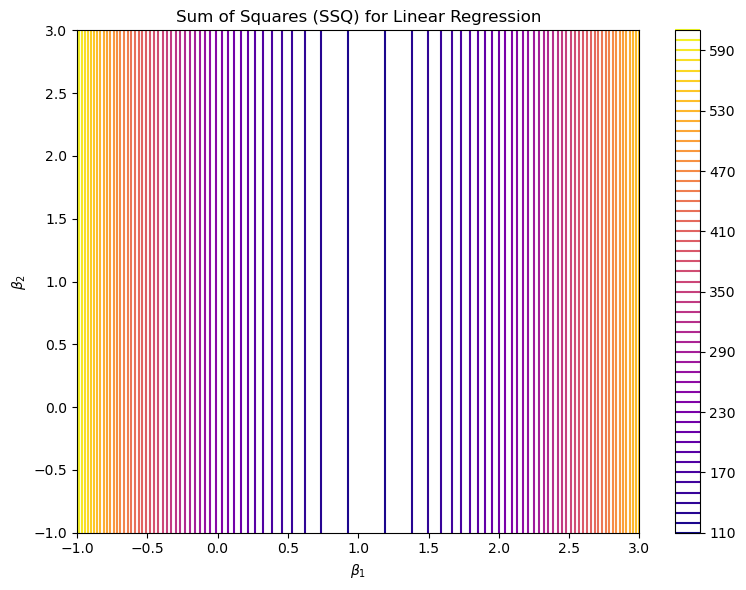

In [21]:
n = 101
ssq = np.zeros((n, n))

# Loop over each pair of beta1 and beta2, and calculate the SSQ
for i in range(n):
    for j in range(n):
        beta = bs[i, j, :]  # Current parameter values
        y_pred = beta.T @ x  # Predicted y values (X.T * beta)
        ssq[i] = np.sum((y - y_pred) ** 2)  # Compute sum of squares

plt.figure(figsize=(8, 6))
cp = plt.contour(bs[..., 0], bs[..., 1], ssq, levels=50, cmap="plasma")
plt.title("Sum of Squares (SSQ) for Linear Regression")
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.colorbar(cp)
plt.tight_layout()
plt.show()

### (c)

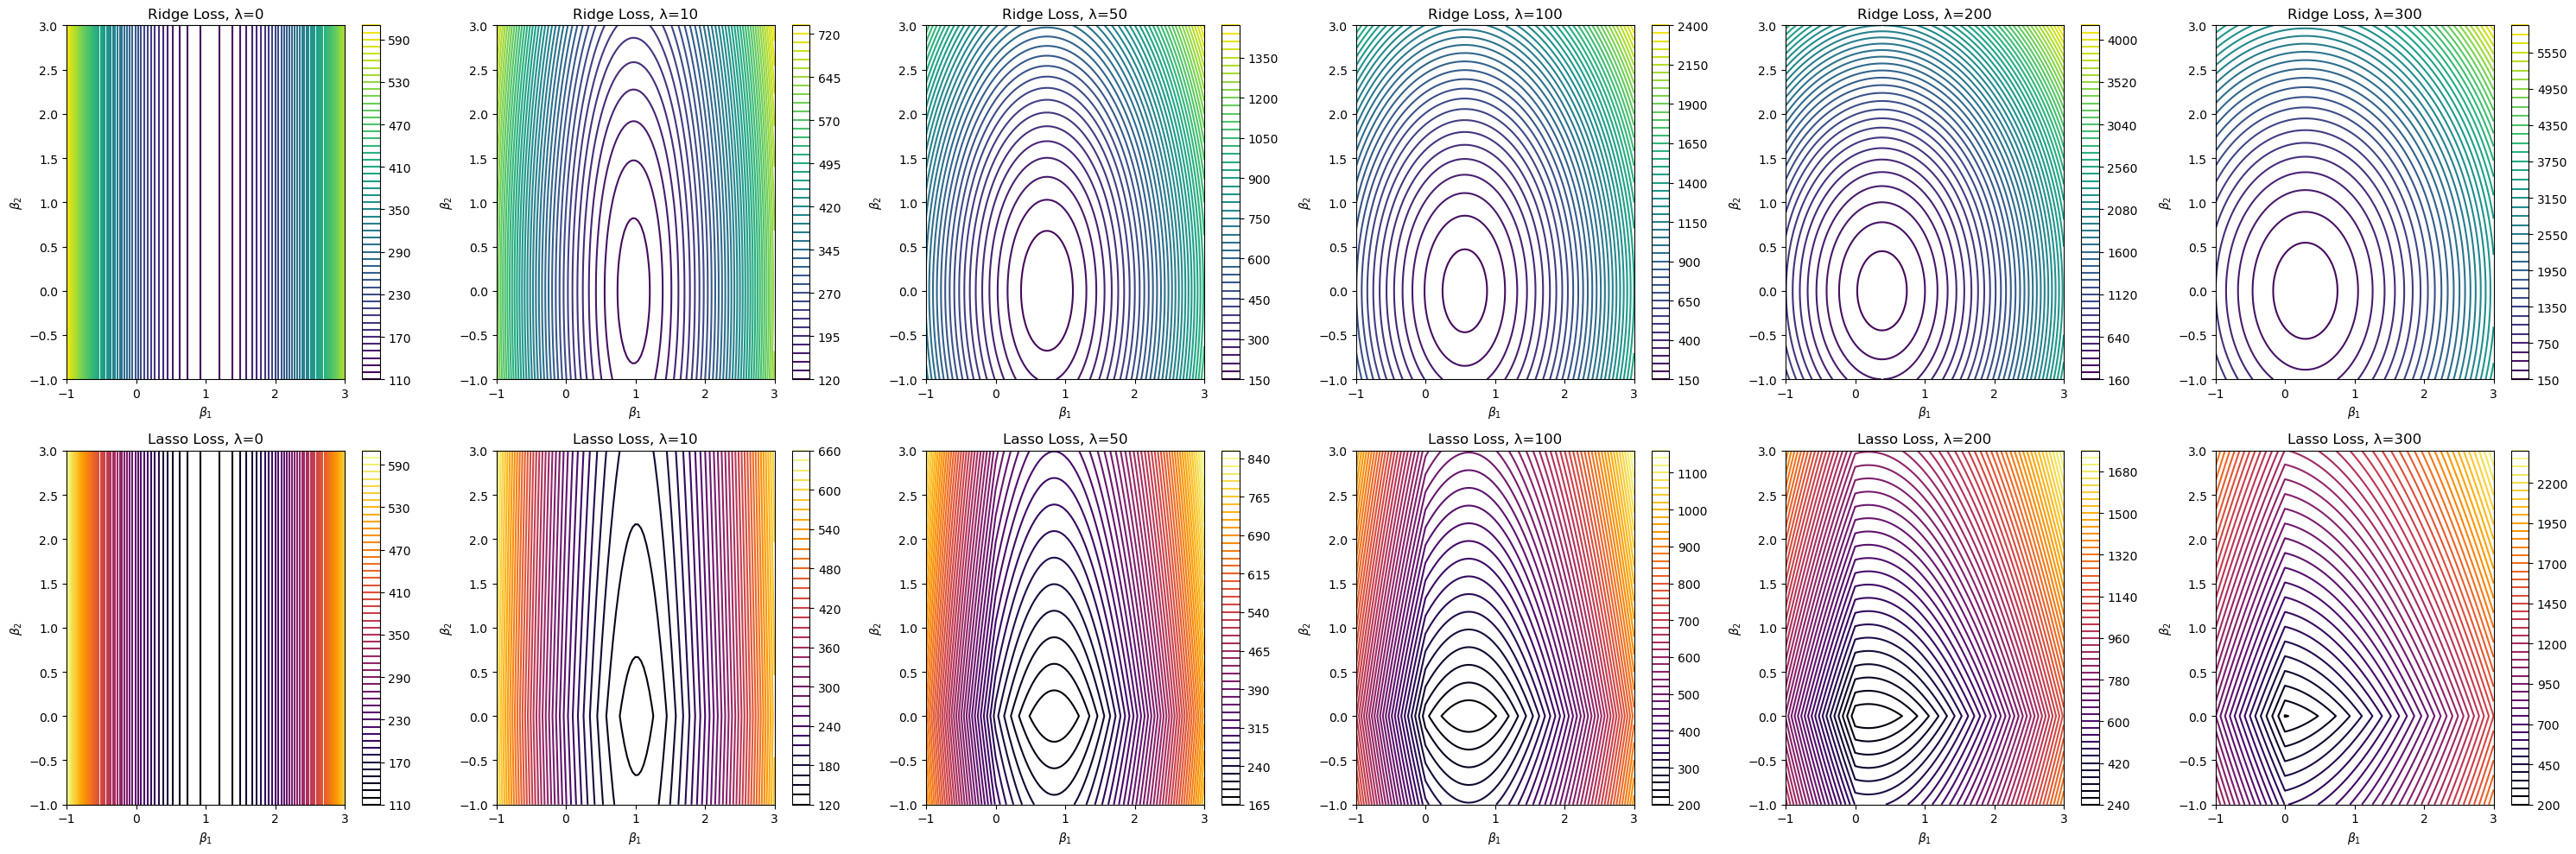

In [26]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]

# Plot the Ridge and Lasso Loss functions
plt.figure(figsize=(30, 10))  # Set the figure size to make it wider

for i, lam in enumerate(lambdas):
    ridge_loss = ssq + lam * (bs**2).sum(axis=-1)
    lasso_loss = ssq + lam * np.abs(bs).sum(axis=-1)

    # Ridge Loss Plot
    plt.subplot(2, len(lambdas), i + 1)
    cp_ridge = plt.contour(
        bs[..., 0], bs[..., 1], ridge_loss, levels=50, cmap="viridis"
    )
    plt.title(f"Ridge Loss, λ={lam}")
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.colorbar(cp_ridge)

    # Lasso Loss Plot
    plt.subplot(2, len(lambdas), len(lambdas) + i + 1)
    cp_lasso = plt.contour(
        bs[..., 0], bs[..., 1], lasso_loss, levels=50, cmap="inferno"
    )
    plt.title(f"Lasso Loss, λ={lam}")
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.colorbar(cp_lasso)

plt.tight_layout()
plt.show()

As we change lambda from zero to infinity, the regularization term becomes the dominant term in the loss function, and thus the shape of the contour lines smoothly changes from the contour line of the loss function of the unregularized problem to the isolines of the regularization terms.

## 4 CT Reconstruction

First, set up the design matrix. (Run this once to save it to the disk)

In [29]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

n_parallel_rays = 70
n_ray_angles = 30
res = (99, 117)
print("Number of pixels in the 2d image:", np.prod(res))
print("Total number of rays:", n_parallel_rays * n_ray_angles)


def rot_mat(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)


kernel = lambda x: np.exp(-(x**2) / sigma**2 / 2)

if not os.path.exists("data/design_matrix.npy"):
    xs = np.arange(0, res[1] + 1) - res[1] / 2  # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0] + 1) - res[0] / 2  # np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    ray_offset_range = [-res[1] / 1.5, res[1] / 1.5]
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = (
        np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi / n_ray_angles
    )

    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack(
        [np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)],
        axis=-1,
    )
    ray_0_directions = np.stack(
        [np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1
    )

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum("oi,aij->aoj", ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum("oi,aij->aoj", ray_0_directions, ray_rot_mats).reshape(
        -1, 2
    )

    sigma = 1
    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[
        :, None
    ]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save("data/design_matrix.npy", design_matrix)
    print(
        f"created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy"
    )

Number of pixels in the 2d image: 11583
Total number of rays: 2100


sino shape: (1, 2100)


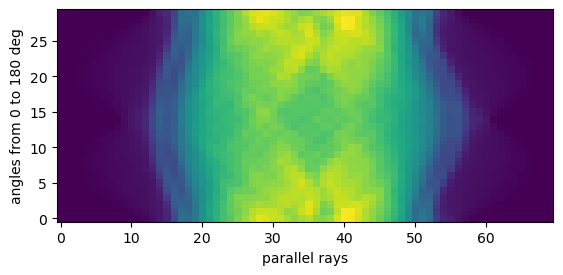

In [32]:
sino = np.load("data/sino.npy")

print(f"sino shape: {sino.shape}")

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin="lower")
# plt.colorbar()
plt.xlabel("parallel rays")
plt.ylabel("angles from 0 to 180 deg")
plt.show()

### (a)

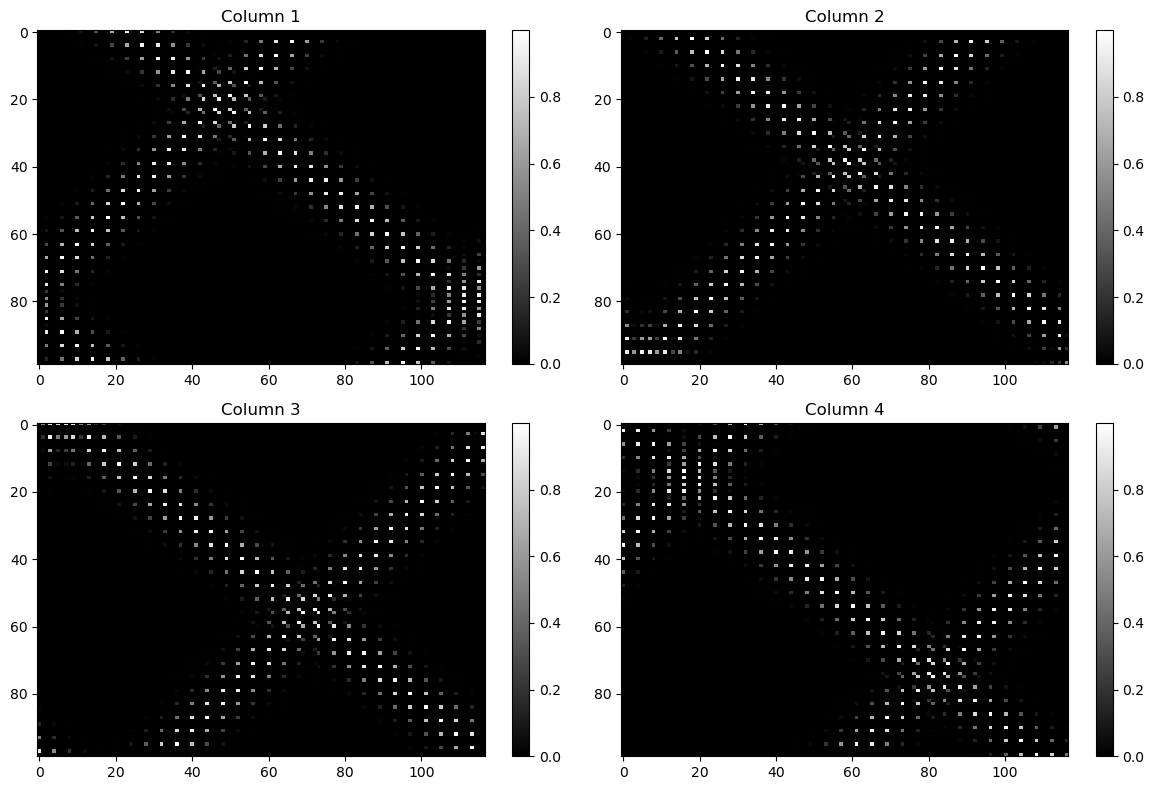

In [57]:
design_matrix = np.load("data/design_matrix.npy")

# TODO: visualize four random columns as images, using an image shape of (99, 117)
n_cols = design_matrix.shape[1]
columns = design_matrix[:, [n_cols // 4 * i for i in range(4)]]
columns = columns.reshape(-1, 99, 117)
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns):
    plt.subplot(2, 2, i + 1)
    plt.imshow(column, cmap="gray", aspect="auto")
    plt.title(f"Column {i + 1}")
    plt.colorbar()

plt.tight_layout()
plt.show()

### (b)

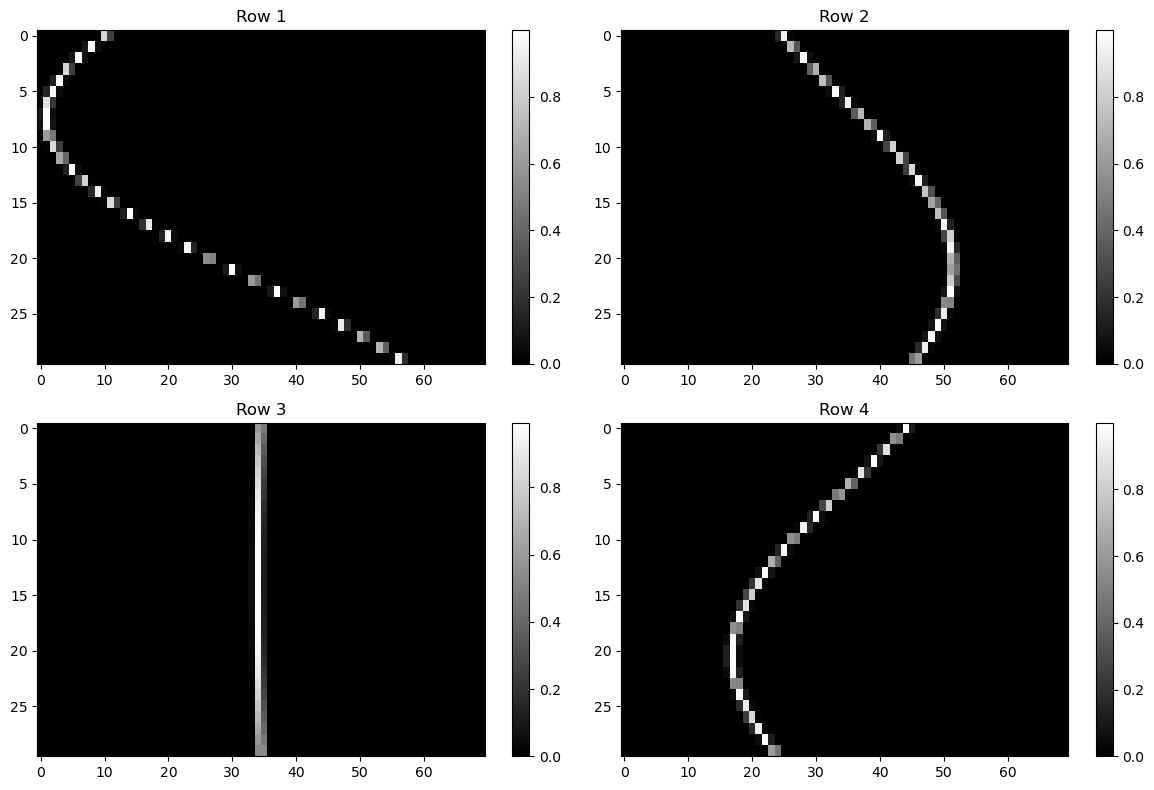

In [59]:
# TODO: visualize four random rows as images, using an images
n_rows = design_matrix.shape[0]
rows = design_matrix[[n_rows // 4 * i for i in range(4)], :].reshape(
    -1, n_angles, n_parallel_rays
)
plt.figure(figsize=(12, 8))
for i, row in enumerate(rows):
    plt.subplot(2, 2, i + 1)
    plt.imshow(row, cmap="gray", aspect="auto")
    plt.title(f"Row {i + 1}")
    plt.colorbar()

plt.tight_layout()
plt.show()

In [60]:
design_matrix.shape

(11583, 2100)

Each row represents the contributions of a single pixel to measurements. Each column represents a single measurement at a specific angle.

### (c)

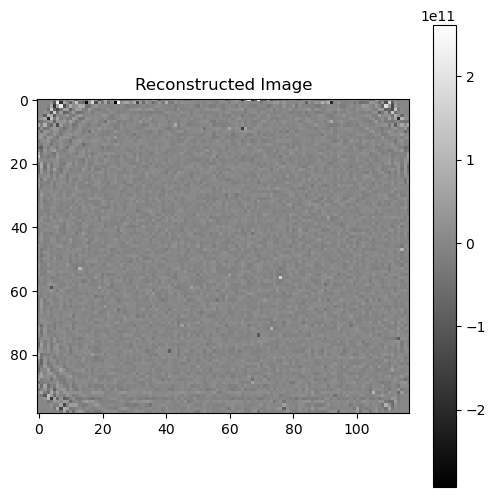

In [53]:
reg = LinearRegression().fit(design_matrix.T, sino.reshape(-1))
# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reg.coef_.reshape(99, 117), cmap="gray", interpolation="none")
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

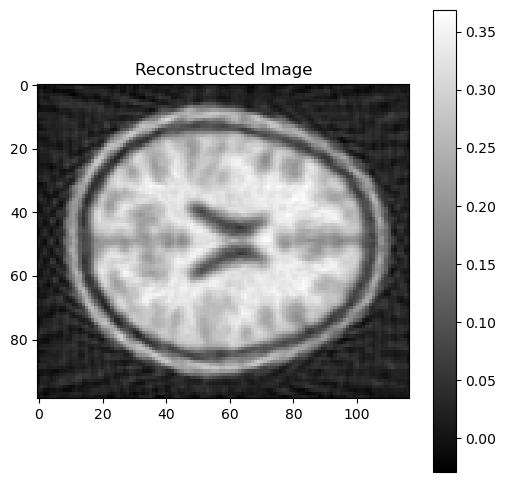

In [54]:
# TODO: solve the reconstruction with ridge regression and visualize the result
# Optional: try out different regularization strengths and oberve the influence
from sklearn.linear_model import Ridge

reg = Ridge().fit(design_matrix.T, sino.reshape(-1))
# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reg.coef_.reshape(99, 117), cmap="gray", interpolation="none")
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

Without regularization, weights blow up, and the resulting "image" is basically pure noise. With ridge regression, we get a fairly reasonable result.

## 5 Bonus: X-Ray Free-Electron Lasers

In [ ]:
sino = np.load("data/sino.npy").reshape(n_angles, n_parallel_rays)
plt.imshow(sino)
plt.title("original sinogram")
plt.show()

order = np.arange(n_angles)
np.random.shuffle(order)
sino_shuffled = sino[order]
plt.imshow(sino_shuffled)
plt.title("shuffled sinogram")
plt.show()